In [2]:
!git clone https://github.com/facebookresearch/detectron2.git
!python -m pip install -e detectron2

fatal: destination path 'detectron2' already exists and is not an empty directory.
Obtaining file:///kaggle/working/detectron2
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 2.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.3/81.3 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 kB 13.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 44.3 MB/s eta 0:00:0000:01
  Created wheel for fvcore: filename=fvcore-0.1.5.post20221221-py3-none-any.whl size=61397 sha256=32b585e07a55d9be6f9cbfa51112b5c5641edd22326fc4791e9e6be7e62d4da7
  Stored in directory: /root/.cache/pip/wheels/65/71/95/3b8fde5c65c6e4a806e0867c1651dcc71a1cb2f3430e8f355f
Successfully built fvcore
  Running setup.py develop for detectron2


In [3]:
import os
print(os.listdir("/kaggle/working"))
%cd /kaggle/working/detectron2


['.virtual_documents', 'detectron2']
/kaggle/working/detectron2


In [ ]:
import os

# List all datasets you've added to this notebook
for root, dirs, files in os.walk("/kaggle/input"):
    for dir in dirs:
        print(os.path.join(root, dir))
    break  # only show top-level folders


In [4]:
import os
import cv2
import json
import numpy as np
from tqdm import tqdm

# --- Configuration ---
DATASET_PATH = "/kaggle/input/apple-dataset/detection"
OUTPUT_DIR = "/kaggle/working/detectron2_coco_data"
CLASS_NAME = "apple"
CLASS_ID = 1

# Ensure output directory exists
os.makedirs(os.path.join(OUTPUT_DIR, "train"), exist_ok=True)
os.makedirs(os.path.join(OUTPUT_DIR, "val"), exist_ok=True)

def create_coco_annotations(image_dir, mask_dir):
    """
    Converts a dataset with PNG masks to COCO JSON format.
    """
    coco_json = {
        "info": {},
        "licenses": [],
        "images": [],
        "annotations": [],
        "categories": [{"id": CLASS_ID, "name": CLASS_NAME, "supercategory": ""}]
    }

    annotation_id = 0
    image_id = 0

    image_filenames = [f for f in os.listdir(image_dir) if f.endswith(('.jpg', '.jpeg', '.png'))]

    print(f"Processing {len(image_filenames)} images from {image_dir}...")

    for filename in tqdm(image_filenames):
        img_path = os.path.join(image_dir, filename)
        mask_path = os.path.join(mask_dir, os.path.splitext(filename)[0] + ".png")

        # Skip if mask file does not exist
        if not os.path.exists(mask_path):
            continue

        # Load image and mask
        image = cv2.imread(img_path)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

        if image is None or mask is None:
            print(f"Warning: Could not read image or mask for {filename}. Skipping.")
            continue

        height, width, _ = image.shape

        # Add image info to COCO JSON
        coco_json['images'].append({
            "id": image_id,
            "width": width,
            "height": height,
            "file_name": filename
        })

        # Get unique pixel values (instances) from the mask
        unique_pixels = np.unique(mask)
        # Filter out background pixel value (0)
        unique_pixels = unique_pixels[unique_pixels != 0]

        for pixel_value in unique_pixels:
            # Create a binary mask for the current instance
            instance_mask = (mask == pixel_value).astype(np.uint8)

            # Find contours
            contours, _ = cv2.findContours(instance_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

            if not contours:
                continue

            # Find the largest contour
            largest_contour = max(contours, key=cv2.contourArea)

            # Convert contour to COCO polygon format
            segmentation = largest_contour.flatten().tolist()

            # Calculate bounding box
            x, y, w, h = cv2.boundingRect(largest_contour)

            # Calculate area
            area = float(cv2.contourArea(largest_contour))

            # Add annotation info to COCO JSON
            coco_json['annotations'].append({
                "id": annotation_id,
                "image_id": image_id,
                "category_id": CLASS_ID,
                "bbox": [x, y, w, h],
                "area": area,
                "segmentation": [segmentation],
                "iscrowd": 0
            })

            annotation_id += 1

        image_id += 1

    return coco_json

# --- Main conversion script ---

# Convert training set
train_image_dir = os.path.join(DATASET_PATH, "train", "images")
train_mask_dir = os.path.join(DATASET_PATH, "train", "masks")
coco_train_data = create_coco_annotations(train_image_dir, train_mask_dir)
with open(os.path.join(OUTPUT_DIR, "train", "instances_train.json"), "w") as f:
    json.dump(coco_train_data, f, indent=4)
print("✅ Training set converted and saved to instances_train.json")

# Convert validation/test set
# Assuming 'test' folder acts as validation
val_image_dir = os.path.join(DATASET_PATH, "test", "images")
val_mask_dir = os.path.join(DATASET_PATH, "test", "masks")
coco_val_data = create_coco_annotations(val_image_dir, val_mask_dir)
with open(os.path.join(OUTPUT_DIR, "val", "instances_val.json"), "w") as f:
    json.dump(coco_val_data, f, indent=4)
print("✅ Validation set converted and saved to instances_val.json")

print("\nAll datasets converted successfully!")
print("The COCO JSON files are located at:")
print(os.path.join(OUTPUT_DIR, "train", "instances_train.json"))
print(os.path.join(OUTPUT_DIR, "val", "instances_val.json"))

Processing 670 images from /kaggle/input/apple-dataset/detection/train/images...


100%|██████████| 670/670 [01:09<00:00,  9.61it/s]


✅ Training set converted and saved to instances_train.json
Processing 331 images from /kaggle/input/apple-dataset/detection/test/images...


100%|██████████| 331/331 [00:00<00:00, 114217.57it/s]

✅ Validation set converted and saved to instances_val.json

All datasets converted successfully!
The COCO JSON files are located at:
/kaggle/working/detectron2_coco_data/train/instances_train.json
/kaggle/working/detectron2_coco_data/val/instances_val.json


In [5]:
import os
import random
from detectron2.data.datasets import register_coco_instances
from detectron2.data import DatasetCatalog
from detectron2.data.build import get_detection_dataset_dicts
from detectron2.data import MetadataCatalog

# --- Step 1: Define the metadata with your class names ---
# The class names must be in a list, in the same order as their IDs (ID 1 corresponds to index 0)
CLASS_NAMES = ["apple"]
apple_metadata = {"thing_classes": CLASS_NAMES}

# --- Step 2: Register the full training dataset with the metadata ---
full_train_dataset_name = "full_apple_train"
register_coco_instances(
    full_train_dataset_name,
    apple_metadata, # Pass the metadata here
    "/kaggle/working/detectron2_coco_data/train/instances_train.json",
    "/kaggle/input/apple-dataset/detection/train/images"
)

# --- Step 3: Get the full list of dictionaries and split the dataset ---
full_dataset_dicts = get_detection_dataset_dicts(full_train_dataset_name, filter_empty=False)

random.seed(42)
random.shuffle(full_dataset_dicts)
train_size = int(len(full_dataset_dicts) * 0.8)

train_dicts = full_dataset_dicts[:train_size]
val_dicts = full_dataset_dicts[train_size:]

# --- Step 4: Register the new split datasets for training and validation ---
def get_train_dicts():
    return train_dicts

def get_val_dicts():
    return val_dicts

# Now, we register these new functions with the DatasetCatalog using new names.
DatasetCatalog.register("apple_train_split", get_train_dicts)
MetadataCatalog.get("apple_train_split").set(thing_classes=CLASS_NAMES)

DatasetCatalog.register("apple_val_split", get_val_dicts)
MetadataCatalog.get("apple_val_split").set(thing_classes=CLASS_NAMES)

print(f"Registered 'apple_train_split' with {len(train_dicts)} images.")
print(f"Registered 'apple_val_split' with {len(val_dicts)} images.")

Registered 'apple_train_split' with 536 images.
Registered 'apple_val_split' with 134 images.


In [16]:
import json

# Define the path to your training annotations file
json_file_path = "/kaggle/working/detectron2_coco_data/train/instances_train.json"

with open(json_file_path, 'r') as f:
    coco_data = json.load(f)

# Get the total number of images and annotations
num_images = len(coco_data["images"])
num_annotations = len(coco_data["annotations"])
num_categories = len(coco_data["categories"])

# Calculate the average number of annotations per image
avg_annotations_per_image = num_annotations / num_images if num_images > 0 else 0

# Print the dataset metrics
print("\n--- Dataset Metrics ---")
print(f"Total number of images in the original dataset: {num_images}")
print(f"Total number of annotations (apples) in the original dataset: {num_annotations}")
print(f"Number of object categories: {num_categories}")
print(f"Average number of apples per image: {avg_annotations_per_image:.2f}")


--- Dataset Metrics ---
Total number of images in the original dataset: 670
Total number of annotations (apples) in the original dataset: 28183
Number of object categories: 1
Average number of apples per image: 42.06


In [12]:
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg
from detectron2 import model_zoo
import os

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))

# Use the new, non-empty dataset names
cfg.DATASETS.TRAIN = ("apple_train_split",)
cfg.DATASETS.TEST = ("apple_val_split",)
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.00025
cfg.SOLVER.MAX_ITER = 5000  # <--- INCREASE THIS VALUE
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)

trainer = DefaultTrainer(cfg)
trainer.train()

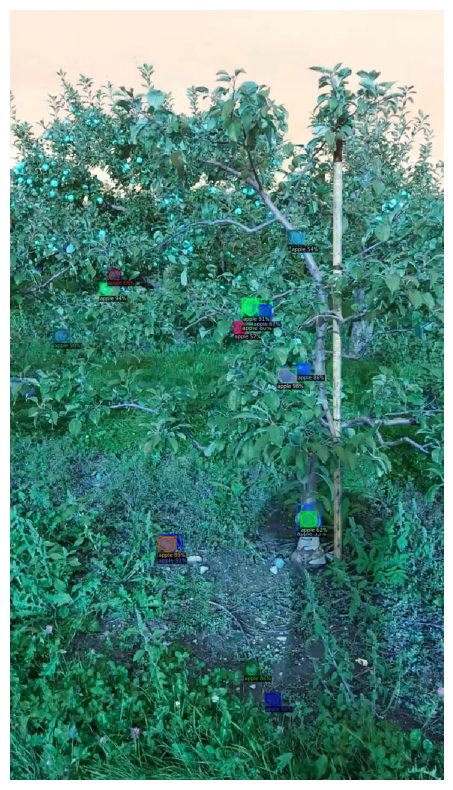

In [13]:
from detectron2.engine import DefaultPredictor
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog
import cv2
import random
import matplotlib.pyplot as plt

# --- 1. Load the trained model's weights ---
# Update the config to use the final trained weights from the output directory
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")

# Set the inference confidence threshold to filter out low-confidence predictions
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5

# Build the predictor object from the updated config
predictor = DefaultPredictor(cfg)

# --- 2. Get and predict on a random image from the validation set ---
# Retrieve the registered validation dataset
# Note: This uses the 'apple_val_split' name from our last successful registration
dataset_dicts = DatasetCatalog.get("apple_val_split")

# Pick a random image dictionary from the list
d = random.choice(dataset_dicts)

# Read the image file using its path from the dictionary
im = cv2.imread(d["file_name"])

# Run the predictor on the image
outputs = predictor(im)

# --- 3. Visualize the predictions ---
# Create a Visualizer instance with the image and metadata
v = Visualizer(
    im[:, :, ::-1],  # Convert BGR to RGB for matplotlib
    metadata=MetadataCatalog.get("apple_val_split"),
    scale=1.2
)

# Draw the predictions (boxes, masks, and labels) on the image
out = v.draw_instance_predictions(outputs["instances"].to("cpu"))

# Display the resulting image
plt.figure(figsize=(10, 10))
plt.imshow(out.get_image()[:, :, ::-1])  # Convert back to RGB for display
plt.axis("off")
plt.show()

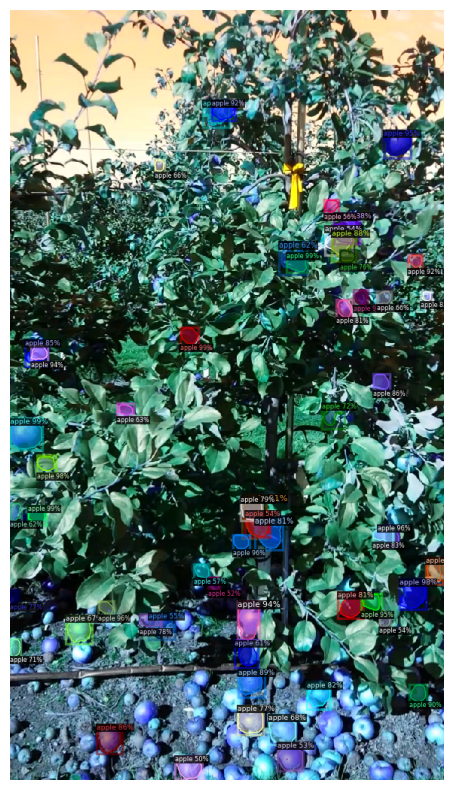

In [14]:
from detectron2.engine import DefaultPredictor
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog
import cv2
import matplotlib.pyplot as plt
import os

# Define the path to your uploaded image
# IMPORTANT: Replace "your_image_name.jpg" with the actual name of your file
my_uploaded_image_path = "/kaggle/input/test-apple/dataset4_front_870.png"

# --- Re-initialize the predictor (if you have restarted the runtime) ---
# If your runtime has not been restarted, you can skip this block
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1
predictor = DefaultPredictor(cfg)
# ----------------------------------------------------------------------

# Load the image using OpenCV
im = cv2.imread(my_uploaded_image_path)

# Run the predictor on the new image
outputs = predictor(im)

# Get the metadata for visualization
apple_metadata = MetadataCatalog.get("apple_val_split")

# Create a Visualizer instance and draw the predictions
v = Visualizer(im[:, :, ::-1], metadata=apple_metadata, scale=0.8)
out = v.draw_instance_predictions(outputs["instances"].to("cpu"))

# Display the image with predictions
plt.figure(figsize=(12, 10))
plt.imshow(out.get_image()[:, :, ::-1])
plt.axis("off")
plt.show()

In [15]:
import os
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2 import model_zoo
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader
import pprint

# --- 1. Load the trained model and set up the predictor ---
# Get the same config as during training
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))

# Point to the final trained weights
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5  # Set a threshold for evaluation
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1

# Create the predictor
predictor = DefaultPredictor(cfg)

# --- 2. Prepare the data loader and evaluator ---
# The validation set name we created earlier
val_dataset_name = "apple_val_split"

# Build the data loader for the validation set
data_loader = build_detection_test_loader(cfg, val_dataset_name)

# Create a COCOEvaluator for segmentation and bounding boxes
evaluator = COCOEvaluator(val_dataset_name, output_dir=cfg.OUTPUT_DIR)

# --- 3. Run the evaluation ---
print("Running evaluation on the validation set...")
results = inference_on_dataset(predictor.model, data_loader, evaluator)

# --- 4. Print the results ---
print("\nEvaluation Results:")
pprint.pprint(results)

# The mAP values are located in the 'segm' (segmentation) and 'bbox' (bounding box) keys.
# We are typically interested in the 'segm' metrics for instance segmentation.
# A full list of metrics will be printed, including:
# - AP: The main mAP (mAP@50-95)
# - AP50: mAP at IoU=50%
# - AP75: mAP at IoU=75%
# You can inspect the 'results' dictionary to see all values.

Running evaluation on the validation set...
Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.197
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.488
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.114
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.191
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.321
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.013
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.106
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.258
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.235
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 